# City of Cape Town - Data Science Unit Code Challenge
Author: Cobus Louw

## Introduction
This notebook serves as the main entry point for the submission, providing the necessary objects to answer Questions 1, 2, and 5. The notebook relies on the `cptcc` package, which was developed specifically for this project. The application was packaged in this way to facilitate code reuse and enable unit testing.

Each section of the notebook is preceded by a markdown cell that identifies the relevant question and provides a brief explanation of the code in that section, as well as the rationale behind the choices made.

The `cptcc` package class is used to answer the majority of the questions, with the logic of these classes abstracted away from the notebook. To view the code of the classes, please refer to the `cptcc` package.

We begin by installing the `cptcc` package and its dependencies.

## Install cptcc package

In [1]:
!pip install . > /dev/null

You should consider upgrading via the '/Users/cobus/.pyenv/versions/3.8.16/envs/cptcc/bin/python3.8 -m pip install --upgrade pip' command.


Next we import the necessary packages and classes, including the `cptcc` package.

Note the structure of the `cptcc` package:

```bash
src
└── cptcc
    ├── __init__.py
    ├── anonymize.py
    ├── cptcc.py
    ├── distance.py
    ├── utils.py
    └── wind.py
```

In [2]:
# !pytest # uncomment to run tests

============================= test session starts ==============================
platform darwin -- Python 3.8.16, pytest-7.2.2, pluggy-1.0.0
rootdir: /Users/cobus/Documents/personal/git-repos/ds_code_challenge, configfile: pytest.ini
plugins: anyio-3.6.2
collected 9 items                                                              

tests/test_anonymize.py::test_add_distance PASSED                        [ 11%]
tests/test_anonymize.py::test_add_random_distance PASSED                 [ 22%]
tests/test_cptcc.py::test_get_geojson_records 
-------------------------------- live log setup --------------------------------
INFO     botocore.credentials:credentials.py:1124 Found credentials in environment variables.
INFO     botocore.credentials:credentials.py:1124 Found credentials in environment variables.
-------------------------------- live log call ---------------------------------
INFO     cptcc.utils:utils.py:18 Function get_geojson Took 2.48 seconds
INFO     botocore.credentials:cred

In [3]:
import yaml
import pandas as pd
import folium
import logging

import cptcc
from cptcc.wind import WindData
from cptcc import CPTDataLoader


logger = logging.getLogger('cptcc')
logger.setLevel(logging.INFO)
handler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logging.getLogger().addHandler(handler)


from dotenv import load_dotenv
load_dotenv()

with open('config.yaml') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
config

data_loader = CPTDataLoader(config['bucket'])


## Question 1
### Data Extraction (if applying for a Data Engineering Position)

<i>
Use the AWS S3 SELECT command to read in the H3 resolution 8 data from `city-hex-polygons-8-10.geojson`. Use the `city-hex-polygons-8.geojson` file to validate your work.

Please log the time taken to perform the operations described, and within reason, try to optimise latency and computational resources used. Please also note the comments above about the nature of the code that we expect.
</i>

For Question 1, we have developed a function that allows us to specify the H3 resolution and the S3 key to be read. The AWS S3 SELECT command is used to retrieve only the relevant records with an H3 resolution of 8, which reduces the response size and speeds up the function. The function returns a geopandas dataframe, with the response from S3 piped directly to Geopandas to create the dataframe. We avoid parsing the string response ourselves i.e. splitting it on `\n` and converting each json string to an dictionary before casting to a Dataframe. The hope is by avoiding `for` loops and other pythonic constructs, we can reduce the latency of the function.

The function also logs the time taken to read the data, using a utility decorator called timeit to log the execution time. 

In [4]:
gdf = data_loader.get_geojson_gdf(
    'city-hex-polygons-8-10.geojson', resolution=8)
gdf.drop(columns=['resolution'], inplace=True)
gdf.head()

2023-04-09 20:30:55,541 - INFO - Function get_geojson Took 2.63 seconds
2023-04-09 20:30:56,013 - INFO - Function get_geojson_gdf Took 3.11 seconds


,index,centroid_lat,centroid_lon,geometry
0,88ad361801fffff,-33.859427,18.677843,"POLYGON ((18.68119 -33.86330, 18.68357 -33.859..."
1,88ad361803fffff,-33.855696,18.668766,"POLYGON ((18.67211 -33.85957, 18.67450 -33.855..."
2,88ad361805fffff,-33.855263,18.685959,"POLYGON ((18.68931 -33.85914, 18.69169 -33.855..."
3,88ad361807fffff,-33.851532,18.676881,"POLYGON ((18.68023 -33.85541, 18.68261 -33.851..."
4,88ad361809fffff,-33.867322,18.678806,"POLYGON ((18.68215 -33.87120, 18.68454 -33.867..."


## Question 2
### Initial Data Transformation (if applying for a Data Engineering and/or Science Position and Visualisation Engineer)
<i>
Join the equivalent of the contents of the file `city-hex-polygons-8.geojson` to the service request dataset, such that each service request is assigned to a single H3 resolution level 8 hexagon. Use the `sr_hex.csv.gz` file to validate your work.

For any requests where the `Latitude` and `Longitude` fields are empty, set the index value to `0`.

Include logging that lets the executor know how many of the records failed to join, and include a join error threshold above which the script will error out. Please motivate why you have selected the error threshold that you have. Please also log the time taken to perform the operations described, and within reason, try to optimise latency and computational resources used.
</i>

To begin with, we download the compressed service requests file (`sr.csv.gz`) from the S3 bucket. We have implemented a general function that enables downloading any .`csv.gz` file from the bucket. The response body is directly fed to Pandas along with the compression argument set to `gzip`. This enables reading the file directly into a Pandas dataframe, without requiring any third-party tools to decompress the file.

Next, we join the service requests to the H3 hexagons. We use the assign_sr_to_gdf function from the `cptcc` package, which takes the service requests dataframe and H3 resolution as arguments. The function returns a dataframe with the service requests joined to the H3 hexagons.

In [5]:
sr_df = data_loader.get_csv_gz_df(key='sr.csv.gz')
sr_gdf = data_loader.assign_sr_to_gdf(gdf, sr_df)
sr_gdf.head(3)

2023-04-09 20:31:03,675 - INFO - Function get_csv_gz_df Took 7.59 seconds
2023-04-09 20:31:28,305 - INFO - Failed to assign 212367 records (22.55%) of service requests to a hexagon
2023-04-09 20:31:29,727 - INFO - Function assign_sr_to_gdf Took 26.05 seconds


,notification_number,reference_number,creation_timestamp,completion_timestamp,directorate,department,branch,section,code_group,code,cause_code_group,cause_code,official_suburb,latitude,longitude,h3_level8_index
0,400583534,9.109492e+09,2020-10-07 06:55:18+02:00,2020-10-08 15:36:35+02:00,URBAN MOBILITY,Roads Infrastructure Management,RIM Area Central,District: Blaauwberg,TD Customer complaint groups,Pothole&Defect Road Foot Bic Way/Kerbs,Road (RCL),Wear and tear,MONTAGUE GARDENS,-33.872839,18.522488,88ad360225fffff
1,400555043,9.108995e+09,2020-07-09 16:08:13+02:00,2020-07-14 14:27:01+02:00,URBAN MOBILITY,Roads Infrastructure Management,RIM Area East,District : Somerset West,TD Customer complaint groups,Manhole Cover/Gully Grid,Road (RCL),Vandalism,SOMERSET WEST,-34.078916,18.848940,88ad36d5e1fffff
2,400589145,9.109614e+09,2020-10-27 10:21:59+02:00,2020-10-28 17:48:15+02:00,URBAN MOBILITY,Roads Infrastructure Management,RIM Area East,District : Somerset West,TD Customer complaint groups,Manhole Cover/Gully Grid,Road (RCL),Vandalism,STRAND,-34.102242,18.821116,88ad36d437fffff


In the above example `212,367` records `22.55%` of the records failed to assign to a hexagon. Let's look at the records that failed to join.

In [6]:
failed_df = sr_gdf[sr_gdf['h3_level8_index']=='0']
print(f'number na lat: {failed_df["latitude"].isna().sum()}')
print(f'number na long: {failed_df["longitude"].isna().sum()}')
failed_df[failed_df['longitude'].notna()]

number na lat: 212364
number na long: 212364


,notification_number,reference_number,creation_timestamp,completion_timestamp,directorate,department,branch,section,code_group,code,cause_code_group,cause_code,official_suburb,latitude,longitude,h3_level8_index
462434,1015950287,9.109002e+09,2020-07-10 14:29:46+02:00,2020-07-10 14:59:05+02:00,WATER AND SANITATION,Distribution Services,Reticulation,Reticulation Water Distribution,WATER,No Water Supply,NaN,NaN,NaN,-34.044257,18.774378,0
804983,1016348681,9.109702e+09,2020-11-09 20:38:59+02:00,2020-12-11 15:54:57+02:00,WATER AND SANITATION,Distribution Services,Reticulation,Reticulation Water Distribution,WATER,Low Water Pressure,NaN,NaN,NaN,-34.044257,18.774378,0
924595,1016488950,9.109941e+09,2020-12-23 07:01:39+02:00,2020-12-23 10:09:12+02:00,ENERGY,Electricity Generation and Distribution,Enterprise Asset Management,CTE Distribution South,ELECTRICITY TECHNICAL COMPLAINTS,No Power,NaN,NaN,BOTTELARY SMALLHOLDINGS 1,-33.904955,18.723060,0


From the above we can see that the majority of records that failed to join did not have a `Latitude` and `Longitude` value. We can also see that there are some records that have a `Latitude` and `Longitude` value but still failed to join. This is likely due to the fact that the service request is outside of the City of Cape Town boundary.

A plot of the service requests that failed to join is shown below. The red points are the service requests that failed to join.

(18.65, 18.8)

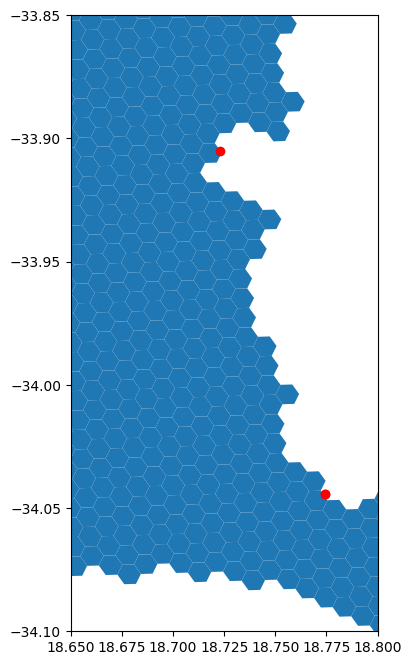

In [18]:
ax = gdf.plot()
failed_df[failed_df['longitude'].notna()][['latitude', 'longitude']]
ax.scatter(failed_df[failed_df['longitude'].notna()]['longitude'], failed_df[failed_df['longitude'].notna()]['latitude'], color='red')
# change fig size
ax.figure.set_size_inches(8, 8)
ax.set_ylim( -34.1, -33.85)
ax.set_xlim(18.65, 18.8)

The above plot shows that the rows with Latitude and Longitude values that failed to join are situated on the borders of the hexagonal grid. Hence, the initial failure rate of `22.55%` seemed high, but it was primarily due to the unavailability of location data.

Currently, the error threshold for the join operation is set at a relatively high `30%`. Ideally, we would prefer a significantly lower failure rate. However, the appropriate error threshold largely depends on the intended use case. For instance, if the service requests are meant for planning purposes, a higher failure rate may be deemed acceptable. Conversely, if they are to be used for emergency response, a high failure rate would be unacceptable.

It is also worth noting that there was a negligible difference (`0.00308%`) between sr_hex.csv.gz and the output of the join operation. This could be attributed to coordinate rounding errors and coordinates that are very close to the hexagon boundary. Nonetheless, the difference is insignificant and can be disregarded.

## Question 5
### Further Data Transformations (if applying for a Data Engineering Position)
### Q5.1

<i>
Create a subsample of the data by selecting all of the requests in `sr_hex.csv.gz` which are within 1 minute of the centroid of the BELLVILLE SOUTH official suburb. You may determine the centroid of the suburb by the method of your choice, but if any external data is used, your code should programmatically download and perform the centroid calculation. Please clearly document your method.
</i>

We start by loading the `sr_hex.csv.gz` from S3 using the `CPTDataLoader` class. The `creation_timestamp` and `completion_time` columns dtypes are converted to datetimes. 

In [8]:
sr_hex_df = data_loader.get_csv_gz_df(key='sr_hex.csv.gz')

sr_hex_df['creation_timestamp'] = pd.to_datetime(
    sr_hex_df['creation_timestamp'], utc=True)
    
sr_hex_df['completion_timestamp'] = pd.to_datetime(
    sr_hex_df['completion_timestamp'], utc=True)

sr_hex_df.head(2)

2023-04-09 20:31:38,509 - INFO - Function get_csv_gz_df Took 8.11 seconds


,reference_number,creation_timestamp,completion_timestamp,directorate,department,branch,section,code_group,code,cause_code_group,cause_code,official_suburb,latitude,longitude,h3_level8_index
0,9.109492e+09,2020-10-07 04:55:18+00:00,2020-10-08 13:36:35+00:00,URBAN MOBILITY,Roads Infrastructure Management,RIM Area Central,District: Blaauwberg,TD Customer complaint groups,Pothole&Defect Road Foot Bic Way/Kerbs,Road (RCL),Wear and tear,MONTAGUE GARDENS,-33.872839,18.522488,88ad360225fffff
1,9.108995e+09,2020-07-09 14:08:13+00:00,2020-07-14 12:27:01+00:00,URBAN MOBILITY,Roads Infrastructure Management,RIM Area East,District : Somerset West,TD Customer complaint groups,Manhole Cover/Gully Grid,Road (RCL),Vandalism,SOMERSET WEST,-34.078916,18.848940,88ad36d5e1fffff


Next we obtain the Centroid of Bellville South


In [9]:
coords = data_loader.get_geoloc('Bellville South, Cape Town')
print(f'Bellville South Centroid: {(coords)}')

2023-04-09 20:31:42,991 - INFO - Function get_geoloc Took 0.55 seconds


Bellville South Centroid: (-33.9161111, 18.6444444)


Next, we filter the entries based on a one-minute threshold around the longitude and latitude of the centroid obtained in the previous step. To achieve this, we utilise a helper function defined in `cptcc.distance`.

In [10]:
minute = 1 / 60
boundary = (coords[0] - minute, coords[0] + minute,
            coords[1] - minute, coords[1] + minute)
subsample_df = sr_hex_df[sr_hex_df[['latitude', 'longitude']].
                      apply(lambda x: cptcc.distance.filter_lon_lat(*x, *boundary), axis=1)]
subsample_df.head(2)

,reference_number,creation_timestamp,completion_timestamp,directorate,department,branch,section,code_group,code,cause_code_group,cause_code,official_suburb,latitude,longitude,h3_level8_index
6,NaN,2020-10-23 08:33:48+00:00,2020-10-26 12:16:49+00:00,URBAN MOBILITY,Roads Infrastructure Management,RIM Area North,District : Bellville,TD Customer complaint groups,Pothole&Defect Road Foot Bic Way/Kerbs,NaN,NaN,GLENHAVEN,-33.917996,18.658031,88ad361a19fffff
12,9.108689e+09,2020-04-22 05:37:53+00:00,2020-07-05 10:11:35+00:00,NaN,NaN,NaN,NaN,TD Customer complaint groups,Paint Markings Lines&Signs,NaN,NaN,BELLVILLE CBD,-33.901032,18.631005,88ad361ac7fffff


### Q5.2

<i>
Augment your filtered subsample of `sr_hex.csv.gz` from (1) with the appropriate wind direction and speed data for 2020 from the Bellville South Air Quality Measurement site, from when the notification was created. All of the steps for downloading and preparing the wind data, as well as the join should be performed programmatically within your script.
</i>

1. The script starts by downloading the `.ods` file and loading it into a Pandas dataframe.
2. As the formatting is somewhat untidy, we clean the dataframe by using the `clean_wind_data` function, which is defined in `WindData`.
   1. This involves removing the redundant rows at the beginning and end of the dataframe.
   2. Changing the datatype of the `date_time` column to `pd.datetime`.
   3. Reformatting the columns to be lowercase, removing spaces, and converting them to `MultiIndex` for column names.


In [11]:
wind_df = WindData.get_df(config['wind_data'])
wind_df = WindData.clean_wind_data(wind_df)
wind_df.head(2)

date_time atlantis_aqm_site                     
                              wind_dir_v(deg) wind_speed_v(m/s)   
0 2020-01-01 00:00:00+00:00             173.0               4.1  \
1 2020-01-01 01:00:00+00:00             177.7               4.0   

  bellville_south_aqm_site                   bothasig_aqm_site   
           wind_dir_v(deg) wind_speed_v(m/s)   wind_dir_v(deg)   
0                    191.0               2.5             163.7  \
1                    209.7               1.6             159.0   

                    goodwood_aqm_station                     
  wind_speed_v(m/s)      wind_dir_v(deg) wind_speed_v(m/s)   
0               5.3                247.8              19.2  \
1               5.4                247.0              17.9   

  khayelitsha_aqm_site                   somerset_west_aqm_site   
       wind_dir_v(deg) wind_speed_v(m/s)        wind_dir_v(deg)   
0                 34.2               1.3                  135.0  \
1                 34.9               1.1                  132.7   

                    tableview_aqm_site                    
  wind_speed_v(m/s)    wind_dir_v(deg) wind_speed_v(m/s)  
0               3.8              179.8               5.2  
1               2.1              177.9               5.2

Since the structure of the dataframe suitable for further processing, we can easily extract both the `wind_dir` and `wind_speed` for the `bellville_south_aqm_site` with a simple lookup. 

In [12]:
SUBURB = 'bellville_south_aqm_site'
bs_wind_df = wind_df[['date_time', SUBURB]]
bs_wind_df.set_index('date_time', inplace=True, drop=True)
bs_wind_df.columns = bs_wind_df.columns.droplevel(0)
bs_wind_df.reset_index(inplace=True)
bs_wind_df.columns = ['wind_timestamp'] + bs_wind_df.columns[1:].to_list()
bs_wind_df.head(5)

,wind_timestamp,wind_dir_v(deg),wind_speed_v(m/s)
0,2020-01-01 00:00:00+00:00,191.0,2.5
1,2020-01-01 01:00:00+00:00,209.7,1.6
2,2020-01-01 02:00:00+00:00,202.5,1.4
3,2020-01-01 03:00:00+00:00,224.7,1.2
4,2020-01-01 04:00:00+00:00,244.3,1.3


The last step of the process is to merge the wind data with the `sr_hex.csv.gz` data based on the `creation_timestamp` column. To accomplish this, we use the` pd.merge_asof` function, which is particularly suitable for joining datasets with uneven time intervals. Since wind data is not available for every timestamp in the s`r_hex.csv.gz` file, the `nearest` option is used to match the closest wind data to each timestamp in the `sr_hex.csv.gz` file.

In [13]:
# merge dataframes based on closest hour
subsample_df = subsample_df.sort_values('creation_timestamp')
bs_wind_df = bs_wind_df.sort_values('wind_timestamp')

subsample_df = pd.merge_asof(subsample_df, bs_wind_df,
                             left_on='creation_timestamp',
                             right_on='wind_timestamp',
                             direction='nearest')

subsample_df.head(2)

,reference_number,creation_timestamp,completion_timestamp,directorate,department,branch,section,code_group,code,cause_code_group,cause_code,official_suburb,latitude,longitude,h3_level8_index,wind_timestamp,wind_dir_v(deg),wind_speed_v(m/s)
0,9.108191e+09,2019-12-31 23:49:58+00:00,2020-01-02 05:31:40+00:00,WATER AND SANITATION,Distribution Services,Reticulation,NaN,SEWER,Sewer: Blocked/Overflow,NaN,NaN,LABIANCE,-33.911720,18.654891,88ad361a11fffff,2020-01-01 00:00:00+00:00,191.0,2.5
1,9.108191e+09,2020-01-01 00:19:27+00:00,2020-01-29 13:26:22+00:00,WATER AND SANITATION,Distribution Services,Reticulation,Reticulation Water Distribution,WATER,Leak at Valve,NaN,NaN,BELLVILLE SOUTH,-33.918821,18.642055,88ad361127fffff,2020-01-01 00:00:00+00:00,191.0,2.5


### Q5.3

<i>
Write a script which anonymises your augmented subsample from (2), but preserves the following precisions (You may use H3 indice or lat/lon coordinates for your spatial data):
   * location accuracy to within approximately 500m
   * temporal accuracy to within 6 hours
Please also remove any columns which you believe could lead to the resident who made the request being identified. We expect in the accompanying report that you will justify as to why this data is now anonymised. Please limit this commentary to less than 500 words. If your code is written in a code notebook such as Jupyter notebook or Rmarkdown, you can include this commentary in your notebook.
</i>s

We start by anonymising the location data by rounding the `longitude` and `latitude` columns to 3 decimal places. This will give us a precision of approximately 500m.

In [14]:
from cptcc.anonymize import add_random_distance

MIN_DISTANCE = 100  # meters
MAX_DISTANCE = 500  # meters

subsample_df[['latitude', 'longitude',]] = \
    subsample_df[['latitude', 'longitude',]].apply(lambda x:
                                                   add_random_distance(lat=x[0],
                                                                       lon=x[1],
                                                                       min_distance=MIN_DISTANCE,
                                                                       max_distance=MAX_DISTANCE))
subsample_df.head(3)


,reference_number,creation_timestamp,completion_timestamp,directorate,department,branch,section,code_group,code,cause_code_group,cause_code,official_suburb,latitude,longitude,h3_level8_index,wind_timestamp,wind_dir_v(deg),wind_speed_v(m/s)
0,9.108191e+09,2019-12-31 23:49:58+00:00,2020-01-02 05:31:40+00:00,WATER AND SANITATION,Distribution Services,Reticulation,NaN,SEWER,Sewer: Blocked/Overflow,NaN,NaN,LABIANCE,-33.918397,18.642543,88ad361a11fffff,2020-01-01 00:00:00+00:00,191.0,2.5
1,9.108191e+09,2020-01-01 00:19:27+00:00,2020-01-29 13:26:22+00:00,WATER AND SANITATION,Distribution Services,Reticulation,Reticulation Water Distribution,WATER,Leak at Valve,NaN,NaN,BELLVILLE SOUTH,-33.909460,18.652761,88ad361127fffff,2020-01-01 00:00:00+00:00,191.0,2.5
2,NaN,2020-01-01 04:42:56+00:00,2020-01-02 05:34:55+00:00,ENERGY,Electricity Generation and Distribution,Electricity Retail Management,Customer Support Services and Rev Man,ELECTRICITY TECHNICAL COMPLAINTS,Identify Cables,NaN,NaN,BELLVILLE SOUTH,NaN,NaN,88ad361ac9fffff,2020-01-01 05:00:00+00:00,245.0,1.6


Next we round all temporal data to the closest 6 hours

In [15]:
ROUNDING = '6H'
subsample_df['wind_timestamp'] = subsample_df['wind_timestamp'].dt.round(ROUNDING)
subsample_df['creation_timestamp'] = subsample_df['creation_timestamp'].dt.round(ROUNDING)
subsample_df['completion_timestamp' ] = subsample_df['completion_timestamp'].dt.round(ROUNDING)
subsample_df.head(10)

,reference_number,creation_timestamp,completion_timestamp,directorate,department,branch,section,code_group,code,cause_code_group,cause_code,official_suburb,latitude,longitude,h3_level8_index,wind_timestamp,wind_dir_v(deg),wind_speed_v(m/s)
0,9.108191e+09,2020-01-01 00:00:00+00:00,2020-01-02 06:00:00+00:00,WATER AND SANITATION,Distribution Services,Reticulation,NaN,SEWER,Sewer: Blocked/Overflow,NaN,NaN,LABIANCE,-33.918397,18.642543,88ad361a11fffff,2020-01-01 00:00:00+00:00,191.0,2.5
1,9.108191e+09,2020-01-01 00:00:00+00:00,2020-01-29 12:00:00+00:00,WATER AND SANITATION,Distribution Services,Reticulation,Reticulation Water Distribution,WATER,Leak at Valve,NaN,NaN,BELLVILLE SOUTH,-33.909460,18.652761,88ad361127fffff,2020-01-01 00:00:00+00:00,191.0,2.5
2,NaN,2020-01-01 06:00:00+00:00,2020-01-02 06:00:00+00:00,ENERGY,Electricity Generation and Distribution,Electricity Retail Management,Customer Support Services and Rev Man,ELECTRICITY TECHNICAL COMPLAINTS,Identify Cables,NaN,NaN,BELLVILLE SOUTH,NaN,NaN,88ad361ac9fffff,2020-01-01 06:00:00+00:00,245.0,1.6
3,9.108191e+09,2020-01-01 06:00:00+00:00,2020-01-02 06:00:00+00:00,WATER AND SANITATION,Commercial Services,Customer Services (Water),Meter Management,WATER MANAGEMENT DEVICE,No Water WMD,NaN,NaN,BELRAIL,NaN,NaN,88ad361ac5fffff,2020-01-01 06:00:00+00:00,194.5,1.7
4,9.108191e+09,2020-01-01 06:00:00+00:00,2020-01-16 12:00:00+00:00,WATER AND SANITATION,Distribution Services,Reticulation,NaN,SEWER,Sewer: Blocked/Overflow,NaN,NaN,BELRAIL,NaN,NaN,88ad361ac5fffff,2020-01-01 06:00:00+00:00,194.5,1.7
5,9.108191e+09,2020-01-01 06:00:00+00:00,2020-01-01 06:00:00+00:00,WATER AND SANITATION,Distribution Services,Reticulation,NaN,SEWER,Sewer: Blocked/Overflow,NaN,NaN,BELRAIL,NaN,NaN,88ad361ac5fffff,2020-01-01 06:00:00+00:00,194.5,1.7
6,9.108191e+09,2020-01-01 06:00:00+00:00,2020-01-02 06:00:00+00:00,WATER AND SANITATION,Distribution Services,Reticulation,NaN,SEWER,Sewer: Blocked/Overflow,General,Roots,LABIANCE,NaN,NaN,88ad361a11fffff,2020-01-01 06:00:00+00:00,176.6,1.5
7,9.108191e+09,2020-01-01 12:00:00+00:00,2020-01-07 12:00:00+00:00,URBAN MOBILITY,Transport Planning & Network Management,Transport Network Facilitation and Dev.,Transport Network Development,TRAFFIC SIGNALS,Stage Stuck,NaN,NaN,BELGRAVIA -BELLVILLE,NaN,NaN,88ad361ae9fffff,2020-01-01 12:00:00+00:00,199.7,3.7
8,9.108191e+09,2020-01-01 12:00:00+00:00,2020-01-02 06:00:00+00:00,WATER AND SANITATION,Commercial Services,Customer Services (Water),Meter Management,WATER MANAGEMENT DEVICE,No Water WMD,NaN,NaN,BELRAIL,NaN,NaN,88ad361ac5fffff,2020-01-01 12:00:00+00:00,187.9,3.7
9,9.108192e+09,2020-01-01 18:00:00+00:00,2020-01-01 18:00:00+00:00,WATER AND SANITATION,Distribution Services,Reticulation,NaN,WATER,Leak at Valve,NaN,NaN,BELLVILLE SOUTH,NaN,NaN,88ad361127fffff,2020-01-01 18:00:00+00:00,192.7,4.2


Incase the reference number is used to identify the resident, we replace it with an untraceable UUID.

In [16]:
# count occurences of each reference number
import uuid
r_number = list(subsample_df['reference_number'].unique())
r_to_id = {r: uuid.uuid4() for r in r_number}
subsample_df['reference_number'] = subsample_df['reference_number'].map(r_to_id)
subsample_df.head(2)

,reference_number,creation_timestamp,completion_timestamp,directorate,department,branch,section,code_group,code,cause_code_group,cause_code,official_suburb,latitude,longitude,h3_level8_index,wind_timestamp,wind_dir_v(deg),wind_speed_v(m/s)
0,546b9e85-978b-455d-a484-cd04d291d564,2020-01-01 00:00:00+00:00,2020-01-02 06:00:00+00:00,WATER AND SANITATION,Distribution Services,Reticulation,NaN,SEWER,Sewer: Blocked/Overflow,NaN,NaN,LABIANCE,-33.918397,18.642543,88ad361a11fffff,2020-01-01 00:00:00+00:00,191.0,2.5
1,f717fc4b-df6b-418d-9021-5a46f48b6ee9,2020-01-01 00:00:00+00:00,2020-01-29 12:00:00+00:00,WATER AND SANITATION,Distribution Services,Reticulation,Reticulation Water Distribution,WATER,Leak at Valve,NaN,NaN,BELLVILLE SOUTH,-33.909460,18.652761,88ad361127fffff,2020-01-01 00:00:00+00:00,191.0,2.5


## Supplementary

In [17]:
m = folium.Map(location=[coords[0], coords[1]], zoom_start=13)
folium.Marker(location=[coords[0], coords[1]]).add_to(m)
m